<a href="https://colab.research.google.com/github/Alfazi/Data-Classification-and-Summarization-Capstone-Student-Developer-Initiative-Wave-8/blob/main/Capstone_Project_Student_Developer_Initiative_Hacktiv8_Zidane_Alfatih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup & Import Library

In [ ]:
!pip install pandas scikit-learn matplotlib wordcloud transformers langchain_community replicate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os, re, string
import replicate

2. Load Dataset

In [3]:
df = pd.read_csv("reddit_mental_health.csv")

print("Dataset shape:", df.shape)
print(df.head())

label_map = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}
df["label"] = df["target"].map(label_map)

Dataset shape: (5957, 4)
   Unnamed: 0                                               text  \
0           0  Welcome to /r/depression's check-in post - a p...   
1           1  We understand that most people who reply immed...   
2           2  Anyone else just miss physical touch? I crave ...   
3           3  I’m just so ashamed. Everyone and everything f...   
4           4  I really need a friend. I don't even have a si...   

                                               title  target  
0  Regular check-in post, with information about ...       1  
1  Our most-broken and least-understood rules is ...       1  
2  I haven’t been touched, or even hugged, in so ...       1  
3                    Being Depressed is Embarrassing       1  
4  I'm desperate for a friend and to feel loved b...       1  


3. Preprocessing

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # remove links
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

4. EDA

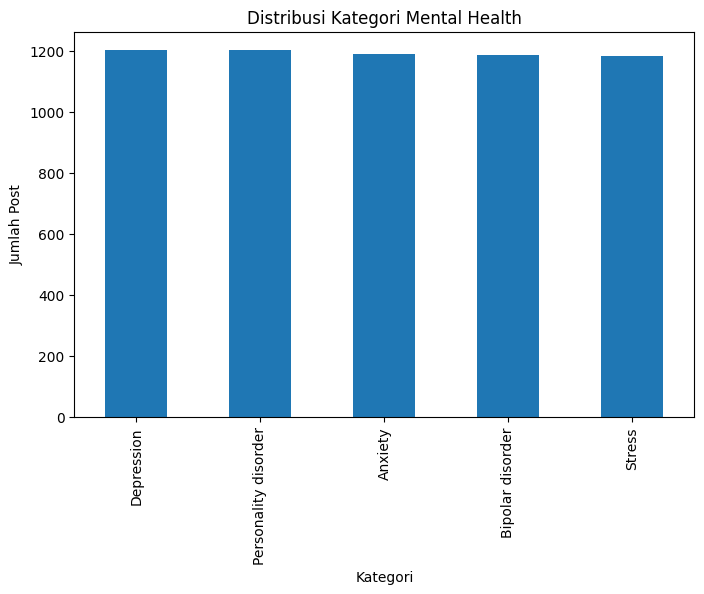

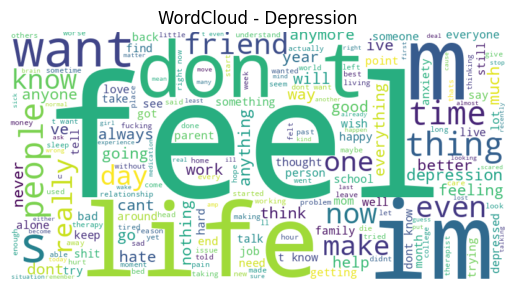

In [5]:
plt.figure(figsize=(8,5))
df["label"].value_counts().plot(kind="bar")
plt.title("Distribusi Kategori Mental Health")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Post")
plt.show()

wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df[df["label"]=="Depression"]["clean_text"]))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Depression")
plt.show()

5. Baseline ML (TF-IDF + Logistic Regression)

=== Classification Report ===
                      precision    recall  f1-score   support

             Anxiety       0.71      0.73      0.72       238
    Bipolar disorder       0.80      0.66      0.72       237
          Depression       0.65      0.69      0.67       241
Personality disorder       0.73      0.63      0.67       240
              Stress       0.65      0.79      0.71       236

            accuracy                           0.70      1192
           macro avg       0.71      0.70      0.70      1192
        weighted avg       0.71      0.70      0.70      1192



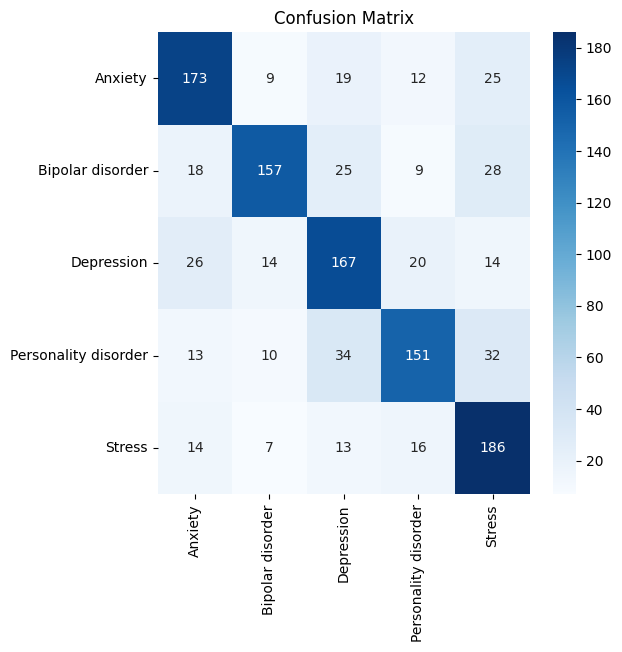

In [6]:
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.show()

6. Integrasi Granite (via Replicate API)

In [1]:
import os
from getpass import getpass
from langchain_community.llms import Replicate
import pandas as pd

# --- Setup API Token ---
api_token = os.environ.get("REPLICATE_API_TOKEN")
if not api_token:
    api_token = getpass("Enter your Replicate API token: ").strip()
    os.environ["REPLICATE_API_TOKEN"] = api_token

# --- Init Granite model via Replicate ---
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(model=model, replicate_api_token=api_token)

def classify_text(text):
    """Call Granite to classify into Stress, Depression, Bipolar, Personality disorder, Anxiety"""
    prompt = f"""
    You are a mental health text classifier.
    Task: classify the following Reddit post into one of these categories:
    [0=Stress, 1=Depression, 2=Bipolar disorder, 3=Personality disorder, 4=Anxiety].

    Respond only in JSON with fields: "label" and "explanation".

    Text: "{text}"
    """
    try:
        return llm.invoke(prompt)
    except Exception as e:
        return f"[ERROR] {e}"

# --- Example test ---
example_post = "I’m just so ashamed. Everyone and everything feels so far away. I feel like drowning in an ocean."
print(classify_text(example_post))

Enter your Replicate API token: ··········
{
  "label": 1,
  "explanation": "The post describes feelings of isolation and a sensation of drowning, which are common symptoms of depression. The use of the word 'ashamed' also suggests a potential struggle with self-worth, another common symptom of depression."
}


In [15]:
import json

def safe_extract(pred):
    """Ambil label dari Granite output (aman)."""
    if isinstance(pred, dict) and "label" in pred:
        return pred["label"]
    elif isinstance(pred, str):
        try:
            data = json.loads(pred)
            if "label" in data:
                return data["label"]
        except:
            return None
    return None

# --- Apply Granite ---
sample_df = df.sample(100, random_state=42).copy()
sample_df["granite_result"] = sample_df["clean_text"].apply(classify_with_granite)

# Extract kolom label & explanation
sample_df["granite_label"] = sample_df["granite_result"].apply(safe_extract)
sample_df["granite_explanation"] = sample_df["granite_result"].apply(
    lambda x: x.get("explanation") if isinstance(x, dict) else str(x)
)

# Simpan tanpa filter, supaya semua hasil (termasuk None/error) tersimpan
sample_df.to_csv("reddit_mental_health_granite_sample.csv", index=False)

print("CSV saved with shape:", sample_df.shape)
sample_df[["clean_text", "label", "granite_label", "granite_explanation"]].head()


CSV saved with shape: (100, 9)


,clean_text,label,granite_label,granite_explanation
1344,is it normal for your behaviour to become more...,Stress,0.0,The post describes feelings of increased errat...
625,hey i came to reddit for advice idk i just fee...,Depression,0.0,"The post describes feelings of exhaustion, lac..."
1433,hello im doing an assignment for my school abo...,Stress,0.0,The text describes a school assignment about s...
2227,parenting is tough kids are stressed looking f...,Stress,0.0,The post discusses the challenges of parenting...
1544,,Stress,NaN,Empty text
